### This Notebook contains Visualization details for some features of the Popular electric vehicle dataset of the state of Washington.


##### Step 1:  Import Required libraries


In [1]:
import pandas as pd
import numpy as np

from bokeh.plotting import figure, show    
from bokeh.io import output_notebook       
from bokeh.models import ColumnDataSource, HoverTool  # need this when preparing our data for a bar/column plot
from bokeh.transform import cumsum
from bokeh.palettes import Category20c
from math import pi

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display


output_notebook()  

Loading BokehJS ...

In [2]:
#Ref Dataset: https://catalog.data.gov/dataset/electric-vehicle-population-data
df = pd.read_csv(r'Electric_Vehicle_Population_Data.csv')
df.head(2)

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJYGDEE1L,King,Seattle,WA,98122.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291,0,37.0,125701579,POINT (-122.30839 47.610365),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
1,7SAYGDEE9P,Snohomish,Bothell,WA,98021.0,2023,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,1.0,244285107,POINT (-122.179458 47.802589),PUGET SOUND ENERGY INC,5.306105e+10


#### Step 2: Data Cleaning

In [4]:
#View columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177866 entries, 0 to 177865
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         177866 non-null  object 
 1   County                                             177861 non-null  object 
 2   City                                               177861 non-null  object 
 3   State                                              177866 non-null  object 
 4   Postal Code                                        177861 non-null  float64
 5   Model Year                                         177866 non-null  int64  
 6   Make                                               177866 non-null  object 
 7   Model                                              177866 non-null  object 
 8   Electric Vehicle Type                              177866 non-null  object

In [5]:
print("Null count per column:")
for column in df.columns:
    null_count = df[column].isnull().sum()
    print(f"{column}: {null_count}")

Null count per column:
VIN (1-10): 0
County: 5
City: 5
State: 0
Postal Code: 5
Model Year: 0
Make: 0
Model: 0
Electric Vehicle Type: 0
Clean Alternative Fuel Vehicle (CAFV) Eligibility: 0
Electric Range: 0
Base MSRP: 0
Legislative District: 389
DOL Vehicle ID: 0
Vehicle Location: 9
Electric Utility: 5
2020 Census Tract: 5


In [6]:
df = df.dropna(subset=['Legislative District', 'Vehicle Location'])
#df.info()
## Rechecking for null values again
null_counts = df.isnull().sum()

# Display columns with null values and their respective counts
print("Columns with null values:")
print(null_counts[null_counts > 0])

Columns with null values:
Series([], dtype: int64)


#### Step 3: Feature Exploration and Feature engineering


In [7]:
#Examining State for unique Valaues
df['State'].unique()

array(['WA'], dtype=object)

In [8]:
# Since the state column has only one value 'WA', the column is not useful. Will drop it and move on to County
df= df.drop(['State'], axis= 1)
df['County'].unique()

array(['King', 'Snohomish', 'Kitsap', 'Thurston', 'Yakima', 'Island',
       'Chelan', 'Skagit', 'Spokane', 'Walla Walla', 'Grant', 'Stevens',
       'Whitman', 'Kittitas', 'Pend Oreille', 'Clark', 'Cowlitz',
       'Jefferson', 'Clallam', 'Klickitat', 'Pierce', 'Grays Harbor',
       'Whatcom', 'Skamania', 'Wahkiakum', 'Benton', 'Franklin', 'Lewis',
       'San Juan', 'Mason', 'Okanogan', 'Douglas', 'Adams', 'Pacific',
       'Asotin', 'Columbia', 'Lincoln', 'Ferry', 'Garfield'], dtype=object)

There are 2 more columns that point to Location: City, and State. So will create a new column Location which is a concatenation of  City and State columns, with each value separated by a comma.

In [9]:
df['Location'] = df['County']+ ', ' + df['City']

len (df['Location'].unique())

511

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177473 entries, 0 to 177865
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         177473 non-null  object 
 1   County                                             177473 non-null  object 
 2   City                                               177473 non-null  object 
 3   Postal Code                                        177473 non-null  float64
 4   Model Year                                         177473 non-null  int64  
 5   Make                                               177473 non-null  object 
 6   Model                                              177473 non-null  object 
 7   Electric Vehicle Type                              177473 non-null  object 
 8   Clean Alternative Fuel Vehicle (CAFV) Eligibility  177473 non-null  object 
 9 

In [11]:
#convert some float columns to int, to include them in correlatin
df['Postal Code'] = df['Postal Code'].astype(int)
df['Legislative District'] = df['Legislative District'].astype(int)

In [12]:
cols_to_check = ['Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility']

# Print unique values for each column using a for loop
for column in cols_to_check:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'Electric Vehicle Type': ['Battery Electric Vehicle (BEV)' 'Plug-in Hybrid Electric Vehicle (PHEV)']
Unique values in column 'Clean Alternative Fuel Vehicle (CAFV) Eligibility': ['Clean Alternative Fuel Vehicle Eligible'
 'Eligibility unknown as battery range has not been researched'
 'Not eligible due to low battery range']


In [13]:
make_groups = df.groupby('Make') # Creates a grouping of the DataFrame by column 'make'
EVType_groups = df.groupby('Electric Vehicle Type') # Creates a grouping of the df by EV tyoe
EVCAF_groups = df.groupby('Clean Alternative Fuel Vehicle (CAFV) Eligibility')

In [14]:

# Function to extract latitude and longitude
from shapely import wkt

def extract_lat_long(point):
    point = wkt.loads(point)
    return point.y, point.x

# Apply function to ' Vehicle location' column  to create latitude and longtitude columns
df['Latitude'], df['Longitude'] = zip(*df['Vehicle Location'].apply(extract_lat_long))
df.head(1)


,VIN (1-10),County,City,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,Location,Latitude,Longitude
0,5YJYGDEE1L,King,Seattle,98122,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291,0,37,125701579,POINT (-122.30839 47.610365),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,"King, Seattle",47.610365,-122.30839


Creating Electric range groups based on Electric Range values

The 'Electric_Range_Category' column has a range of values so will group based on observations.
By creating this new column, we can better understand the distribution of electric vehicle ranges in our dataset 

In [15]:
#function to create new column
def create_electric_range_category(df, column='Electric Range'):
    def categorize_range(electric_range):
        if electric_range == 0:
            return "Unknown"
        elif electric_range < 150:
            return "Short"
        elif electric_range < 300:
            return "Medium"
        else:
            return "Long"

    df['Electric_Range_Category'] = df[column].apply(categorize_range)
    return df

df = create_electric_range_category(df, column='Electric Range')

df.head(1)

,VIN (1-10),County,City,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,Location,Latitude,Longitude,Electric_Range_Category
0,5YJYGDEE1L,King,Seattle,98122,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291,0,37,125701579,POINT (-122.30839 47.610365),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,"King, Seattle",47.610365,-122.30839,Medium


In [16]:
df.describe()

,Postal Code,Model Year,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,2020 Census Tract,Latitude,Longitude
count,177473.000000,177473.000000,177473.000000,177473.000000,177473.000000,1.774730e+05,1.774730e+05,177473.000000,177473.000000
mean,98260.199332,2020.517115,58.826548,1070.609839,29.127710,2.202527e+08,5.303981e+10,47.465564,-122.084367
std,303.694979,2.989179,91.973457,8346.920672,14.892259,7.585304e+07,1.620333e+07,0.610749,1.018134
min,98001.000000,1997.000000,0.000000,0.000000,1.000000,4.385000e+03,5.300195e+10,45.583590,-124.625140
25%,98052.000000,2019.000000,0.000000,0.000000,18.000000,1.815241e+08,5.303301e+10,47.357985,-122.394185
50%,98122.000000,2022.000000,0.000000,0.000000,33.000000,2.282691e+08,5.303303e+10,47.610365,-122.291790
75%,98370.000000,2023.000000,75.000000,0.000000,42.000000,2.548504e+08,5.305307e+10,47.715580,-122.151665
max,99403.000000,2024.000000,337.000000,845000.000000,49.000000,4.792548e+08,5.307794e+10,48.996340,-117.044370


#### Step 4: Visualizations 

##### Top Electric Vehicles by distribution - Bokeh

In [17]:

from bokeh.transform import factor_cmap
from bokeh.palettes import Viridis256
from bokeh.palettes import Bright6

# Count the number of electric vehicles by make and get the top 12 makes
ev_counts_by_make = df['Make'].value_counts().nlargest(12)
ev_counts_by_make = ev_counts_by_make[::-1]  # To ensure plots are sorted from highest to lowest

# Creating Bokeh figure
p = figure(y_range=list(ev_counts_by_make.index), height=400, width=600, title=" Visual 1: Top 12 Electric Vehicle Makes by Count",
           toolbar_location=None, tools="")

source = ColumnDataSource(data=dict(make=list(ev_counts_by_make.index), counts=ev_counts_by_make.values))

# Define a color palette with 12 colors
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78']

# Plotting horizontal bars for each make
plt.figure(figsize=(12, 10))

renderer = p.hbar(y='make', right='counts', height=0.8, source=source, line_color="white",
                  fill_color=factor_cmap('make', palette=palette, factors=list(ev_counts_by_make.index)))

# Add percentages to the bars
total_count = sum(ev_counts_by_make.values)
for i, count in enumerate(ev_counts_by_make.values):
    percentage = count / total_count * 100
    p.text(x=count + 5, y=i, text=[f'{percentage:.1f}%'], text_font_size='9px', text_align='left')

# Plot with labels
p.xaxis.axis_label = "Number of Vehicles"
p.yaxis.axis_label = "Make"

# Center the plot position
p.toolbar.logo = None
p.toolbar_location = None

# Show plot
show(p)


<Figure size 1200x1000 with 0 Axes>

We can see clearly that Tesla has the highest distribution of electric vehicles 

#### Visual 2: Trend of Electric Vehicle over the years - Bokeh

In [ ]:
len(df['DOL Vehicle ID'].unique())
#This is the unique Identifier column in the data

In [18]:


# Calculate the count of unique EVs per year
ev_counts = df['Model Year'].value_counts().sort_index()

# Convert 'Model Year' index to string for Bokeh interpretation
Year = ev_counts.index.astype(str)

# Create a ColumnDataSource
source = ColumnDataSource(data=dict(Year=Year, ev_counts=ev_counts))

# Create Bokeh figure
visual = figure(height=600, width=600, title="Visual 2 :  Yearly Trend of EV vehicles",
                x_axis_label="Year", y_axis_label="Count of EVs")

# Plot line chart
visual.line(x='Year', y='ev_counts', line_width=2, source=source)

# Show the plot
show(visual)


We can see from the  visual that there was a spike in EV Vehicles in 2023 compared to other years.

In [25]:

from bokeh.palettes import Category20c

# Count the number of electric vehicles by location and get the top 12 locations
ev_counts_by_location = df['Location'].value_counts().nlargest(12)
ev_counts_by_location = ev_counts_by_location[::-1]  # To ensure plots are sorted from highest to lowest

data = pd.Series(ev_counts_by_location).reset_index(name='value')
data['angle'] = data['value']/data['value'].sum() * 2*pi
data['color'] = Category20c[len(ev_counts_by_location)]
# Add percentage column
total_count = data['value'].sum()
data['percentage'] = ((data['value'] / total_count) * 100).round(1).astype(str) + '%' #To rpund up and include % sign

p = figure(height=350, title="Visual 4 : Top Locations with highest Electric Vehicles", toolbar_location=None,
          tools="hover", tooltips="@Location: @percentage", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='Location', source=data)

p.axis.axis_label = None
p.axis.visible = False
p.grid.grid_line_color = None

show(p)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


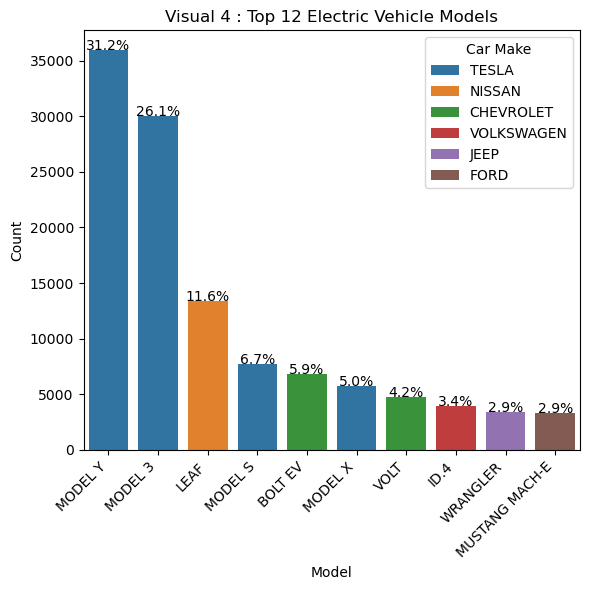

In [26]:
model_counts = df['Model'].value_counts().head(10)  # Select the top 10 models

make_dict = {}
for model in model_counts.index:
    makes = df[df['Model'] == model]['Make'].unique()
    make_dict[model] = ', '.join(makes)

# Plotting bars
plt.figure(figsize=(6, 6))
sns.barplot(x=model_counts.index, y=model_counts.values, hue=[make_dict[model] for model in model_counts.index], dodge=False)
plt.title('Visual 4 : Top 12 Electric Vehicle Models')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Car Make', )
plt.tight_layout()


# Adding percentage distribution for each bar
total_count = sum(model_counts.values)
for i, count in enumerate(model_counts.values):
    percentage = count / total_count * 100
    plt.text(i, count + 0.5, f'{percentage:.1f}%', ha='center')

plt.show()

#### Next is the distrbution of Electric Vehicle Types

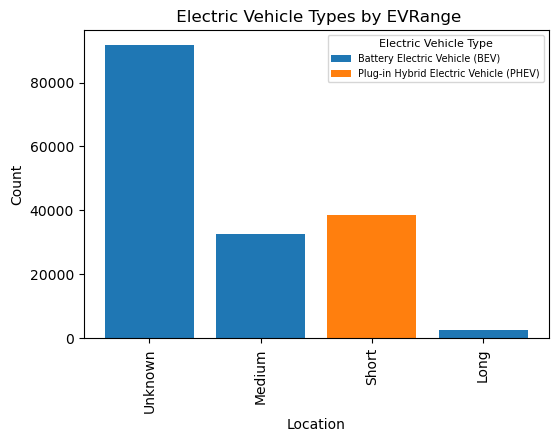

In [30]:
plt.figure(figsize=(6, 4))

EVtype_by_EVRange = {}

for ev_type in df['Electric Vehicle Type'].unique():
    ev_type_data = df[df['Electric Vehicle Type'] == ev_type]
    EVR_counts = ev_type_data['Electric_Range_Category'].value_counts().head() 
    plt.bar(EVR_counts.index, EVR_counts.values, label=ev_type)
    
    #Electric_Range_Category
    EVtype_by_EVRange[ev_type] = EVR_counts.index.tolist()

plt.title(' Electric Vehicle Types by EVRange')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=90)

top_legend_labels = [f"{ev_type}" for ev_type in df['Electric Vehicle Type'].unique()]

plt.legend(top_legend_labels, title='Electric Vehicle Type', title_fontsize=8, fontsize='x-small', bbox_to_anchor=(1, 1), loc='upper right')

plt.show()

We can see from this visual that the Hybrid  EV vehicles belonged to the 'Short' Electronic range Category

<Figure size 500x400 with 0 Axes>

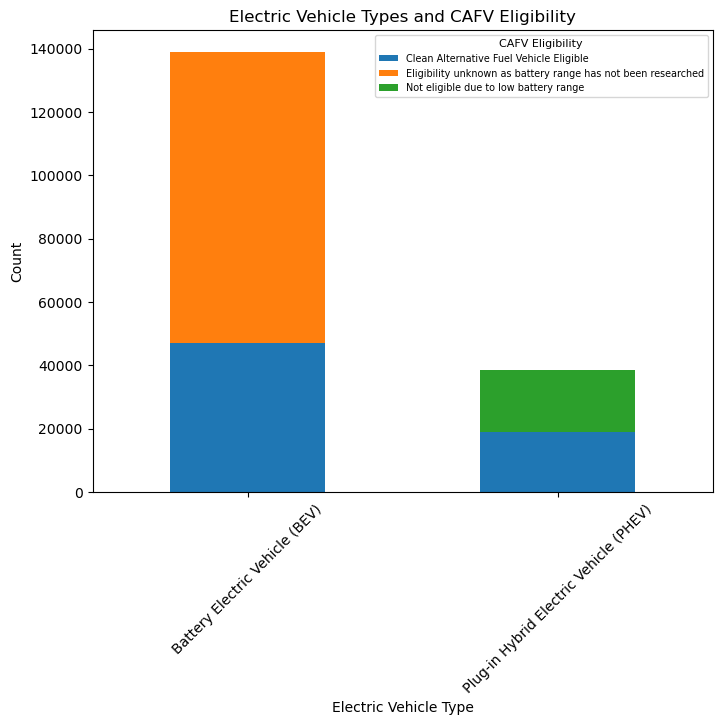

In [31]:
plt.figure(figsize=(5, 4))

ev_type_cafv =df.groupby(['Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility'])['Electric Vehicle Type'].count().unstack()
ev_type_cafv.plot(kind='bar', stacked=True, figsize=(8, 6) )
plt.legend(title='CAFV Eligibility', title_fontsize=8, fontsize='x-small', bbox_to_anchor=(1, 1), loc='upper right')

plt.title('Electric Vehicle Types and CAFV Eligibility')
plt.xlabel('Electric Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


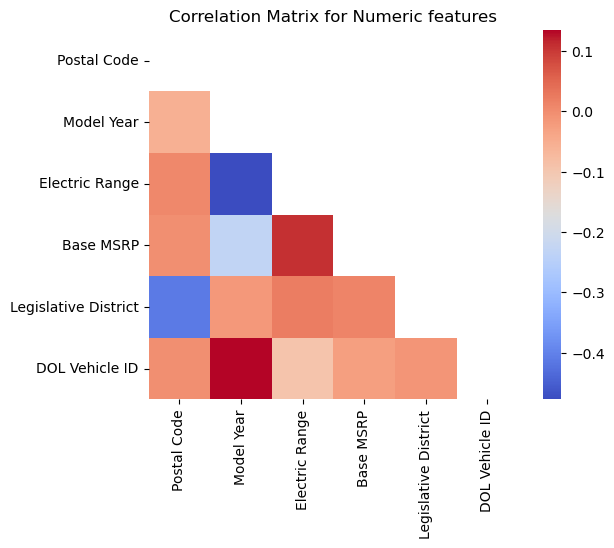

<Figure size 800x600 with 0 Axes>

In [32]:
# Select only numeric columns from the DataFrame
numeric_df = df.select_dtypes(include=['int64', 'int32'])

# Create a correlation heatmap for the numeric columns
corr_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8}, mask=mask)

# Adjust aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Correlation Matrix for Numeric features')

plt.figure(figsize=(8, 6))

# Plot correlation matrix
plt.show()


This visual shows correlated features here in case of further analysis or regresssion.


 #### Visual 6: Geo Maps to be plotted from location coordinates

In [33]:
df.head(1)

,VIN (1-10),County,City,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,Location,Latitude,Longitude,Electric_Range_Category
0,5YJYGDEE1L,King,Seattle,98122,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291,0,37,125701579,POINT (-122.30839 47.610365),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,"King, Seattle",47.610365,-122.30839,Medium



#from bokeh.tile_providers import get_provider, Vendors



# Define the coordinates range for Vehicle Location
x_range = (-124.625140, -117.044370)
y_range = (45.583590, 48.996340)

# Get the tile provider for the map
tile_provider = get_provider(Vendors.CARTODBPOSITRON_RETINA)

# Create a figure with the map
p = figure(x_range=x_range, y_range=y_range,
           x_axis_type="mercator", y_axis_type="mercator",
           width=800, height=600, title="    Visual 8   : Vehicle Locations on Map")
p.add_tile(tile_provider)

# Create a ColumnDataSource from the DataFrame
source = ColumnDataSource(df)

# Plot the car locations on the map
p.circle(x='Longitude', y='Latitude', size=4, color='blue', alpha=0.7, source=source)

# Add hover tool
hover = HoverTool()
hover.tooltips = [("City", "@City"), ("Car Make", "@{Make}"),("Car Model", "@{Model}"), ("Car Type", "@{Electric Vehicle Type}")]
p.add_tools(hover)

# Show the plot
#show(p)
